In [1]:
%cd 'Q:\Dropbox\python\QSim\'

Q:\Dropbox\python\QSim


In [2]:
from scipy.io import *
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.ndimage import filters
from pyfield import *
from scipy.integrate import ode

In [3]:
s = np.load('data\sdo.x766y1118.20110225.npz')

data1 = s['hmi'][120,:,:].astype(np.float64)
data2 = s['hmi'][138,:,:].astype(np.float64)

In [4]:
r = 3

gx = (np.roll(data1,-1,0) - np.roll(data1,1,0))*0.5
gy = (np.roll(data1,-1,1) - np.roll(data1,1,1))*0.5
gt = data2 - data1

a11 = filters.gaussian_filter(gx**2,r)
a22 = filters.gaussian_filter(gy**2,r)
a12 = filters.gaussian_filter(gx*gy,r)

det_a = a11*a22 - a12**2
q = det_a/(det_a**2+1)

b1 = filters.gaussian_filter(gx*gt,r)
b2 = filters.gaussian_filter(gy*gt,r)


p1=(a12*b2-a22*b1)*q
p2=(a12*b1-a11*b2)*q



In [43]:
def cross(a, b):
    return [a[i]*b[i+1]-a[i+1]*b[i] for i in [1,-1,0]]

def jacobian(X):
    J = [[(np.roll(X[i],-1,j)-np.roll(X[i],1,j))*0.5 for j in range(0,3)] for i in range(0,3)]
    for i in range(0,3):
        J[i][0][0,:,:] = -1.5*X[i][0,:,:]+2*X[i][1,:,:]-0.5*X[i][2,:,:]
        J[i][0][-1,:,:] = 1.5*X[i][-1,:,:]-2*X[i][-2,:,:]+0.5*X[i][-3,:,:]
        J[i][1][:,0,:] = -1.5*X[i][:,0,:]+2*X[i][:,1,:]-0.5*X[i][:,2,:]
        J[i][1][:,-1,:] = 1.5*X[i][:,-1,:]-2*X[i][:,-2,:]+0.5*X[i][:,-3,:]
        J[i][2][:,:,0] = -1.5*X[i][:,:,0]+2*X[i][:,:,1]-0.5*X[i][:,:,2]
        J[i][2][:,:,-1] = 1.5*X[i][:,:,-1]-2*X[i][:,:,-2]+0.5*X[i][:,:,-3]  
        
    return J

def div(X):
    J = [(np.roll(X[i],-1,i)-np.roll(X[i],1,i))*0.5 for j in range(0,3)]
    for i in range(0,3):
        J[0][0,:,:] = -1.5*X[0][0,:,:]+2*X[0][1,:,:]-0.5*X[0][2,:,:]
        J[0][-1,:,:] = 1.5*X[0][-1,:,:]-2*X[0][-2,:,:]+0.5*X[0][-3,:,:]
        J[1][:,0,:] = -1.5*X[1][:,0,:]+2*X[1][:,1,:]-0.5*X[1][:,2,:]
        J[1][:,-1,:] = 1.5*X[1][:,-1,:]-2*X[1][:,-2,:]+0.5*X[1][:,-3,:]
        J[2][:,:,0] = -1.5*X[2][:,:,0]+2*X[2][:,:,1]-0.5*X[2][:,:,2]
        J[2][:,:,-1] = 1.5*X[2][:,:,-1]-2*X[2][:,:,-2]+0.5*X[2][:,:,-3]  
        
    return np.sum(J,0)


def hessian(X):
    J = jacobian(X)   
    H = [[[(-2*X[i] + np.roll(X[i],-1,k)+np.roll(X[i],1,k)) if k == j else 
           (np.roll(J[i][j],-1,k)-np.roll(J[i][j],1,k))*0.5 for k in range(0,j+1)] for j in range(0,3)] for i in range(0,3)]
    
    for i in range(0,3):
        
        H[i][0][0][0,:,:] = 2*X[i][0,:,:]-5*X[i][1,:,:]+4*X[i][2,:,:]-X[i][3,:,:]
        H[i][0][0][-1,:,:] = 2*X[i][-1,:,:]-5*X[i][-2,:,:]+4*X[i][-3,:,:]-X[i][-4,:,:]
        H[i][1][1][:,0,:] = 2*X[i][:,0,:]-5*X[i][:,1,:]+4*X[i][:,2,:]-X[i][:,3,:]
        H[i][1][1][:,-1,:] = 2*X[i][:,-1,:]-5*X[i][:,-2,:]+4*X[i][:,-3,:]-X[i][:,-4,:]
        H[i][2][2][:,:,0] = 2*X[i][:,:,0]-5*X[i][:,:,1]+4*X[i][:,:,2]-X[i][:,:,3]
        H[i][2][2][:,:,-1] = 2*X[i][:,:,-1]-5*X[i][:,:,-2]+4*X[i][:,:,-3]-X[i][:,:,-4]
        
        
        
        for j in (1,2):
            H[i][j][0][0,:,:] = -1.5*J[i][j][0,:,:]+2*J[i][j][1,:,:]-0.5*J[i][j][2,:,:]
            H[i][j][0][-1,:,:] = 1.5*J[i][j][-1,:,:]-2*J[i][j][-2,:,:]+0.5*J[i][j][-3,:,:]

        
        H[i][2][1][:,0,:] = -1.5*J[i][2][:,0,:]+2*J[i][2][:,1,:]-0.5*J[i][2][:,2,:]
        H[i][2][1][:,-1,:] = 1.5*J[i][2][:,-1,:]-2*J[i][2][:,-2,:]+0.5*J[i][2][:,-3,:]
        

    return (H, J)       

def det(a):
    return np.sum([a[0][i-1]*(a[1][i]*a[2][i+1]-a[1][i+1]*a[2][i]) for i in [1,-1,0]],0)

def rot(B, X):
    hes = hessian(X)
    J = hes[1]
    H = hes[0]
    detJ = det(J)
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]
    dB = [np.gradient(B[i]) for i in range(0,3)]
    Bx = [np.sum([J[i][j]*B[j] for j in range(0,3)],0)/detJ for i in range(0,3)]
  
    DdetJ = [det([[H[i][j][0],J[i][1],J[i][2]] for i in range(0,3)])+
            det([[J[i][0],H[i][max(j,1)][min(j,1)],J[i][2]] for i in range(0,3)])+
            det([[J[i][0],J[i][1],H[i][max(j,2)][min(j,2)]] for i in range(0,3)]) for j in range(0,3)]

    dBx = [[(np.sum([J[i][k]*dB[k][j] + H[i][max(k,j)][min(k,j)]*B[k] for k in range(0,3)],0) -
                DdetJ[j]*Bx[i])/detJ for j in range(0,3)] for i in range(0,3)]
        
    rotB = [np.sum([Jb[i][j]*dBx[i+1][j]-Jb[i+1][j]*dBx[i][j] for j in range(0,3)],0) for i in [1,-1,0]]
    return rotB

def force(B, X):
    hes = hessian(X)
    J = hes[1]
    H = hes[0]
    detJ = det(J)
    Jb = [[(J[i][j]*J[i+1][j+1] - J[i+1][j]*J[i][j+1])/detJ for j in [-2,-1,0]] for i in [1,-1,0]]
    dB = [np.gradient(B[i]) for i in range(0,3)]
    Bx = [np.sum([J[i][j]*B[j] for j in range(0,3)],0)/detJ for i in range(0,3)]
    Bx2 = np.sum(np.power(B,2),0)+1e4
    
    DdetJ = [np.sum([[H[i][max(j,k)][min(j,k)]*Jb[i][j] for i in range(0,3)] for j in range(0,3)],(0,1))*detJ for k in range(0,3)]    

    dBx = [[(np.sum([J[i][k]*dB[k][j] + H[i][max(k,j)][min(k,j)]*B[k] for k in range(0,3)],0) -
                DdetJ[j]*Bx[i])/detJ for j in range(0,3)] for i in range(0,3)]
    
    force = [np.sum([B[j]*dBx[i][j]/detJ - np.sum([Bx[k]*dBx[k][j] for k in range(0,3)],0)*Jb[i][j]
                     for j in range(0,3)],0)/Bx2 for i in range(0,3)]
    
    return force




In [44]:
dim = [64,64,8]
B = np.gradient(-PField(data1, 8).astype(np.float64))
X = np.mgrid[0:dim[0], 0:dim[1], 0:dim[2]].astype(np.float64)

V = np.array([np.zeros(dim) for i in range(0,3)])

#p1 = np.random.rand(dim[0],dim[1])*0.5
#p2 = np.random.rand(dim[0],dim[1])*0.5

for i in range(0,dim[2]):
    X[0][:,:,i] = X[0][:,:,i] + p1*(np.cos(i*np.pi/dim[2])+1)*0.5
    X[1][:,:,i] = X[1][:,:,i] + p2*(np.cos(i*np.pi/dim[2])+1)*0.5


#X[0] = (X1[0]-dim[0]/2)*np.cos(h) - (X1[1]-dim[1]/2)*np.sin(h) + dim[0]/2
#X[1] = (X1[0]-dim[0]/2)*np.sin(h) + (X1[1]-dim[1]/2)*np.cos(h) + dim[1]/2

In [45]:
xsh = X.shape

X1 = np.array(X)

B2 = np.max(np.sum([B[i]**2 for i in range(0,3)],0))
fmax = 1e-5
                    
def f(t,y):
    y.shape = xsh
    f = np.array(force(B,y), dtype = np.float32)
    f[:,:,:,0] = 0
    return f.flatten()

r = ode(f).set_integrator('dop853').set_initial_value(X.flatten(),0)


dt = 1

while r.t < 100 and r.successful():
    Y = np.array(r.integrate(r.t+dt))
    Y.shape = xsh
    
    fig = plt.figure(0,[8,8])
    ax = fig.add_subplot(111, projection='3d')
    for i in range(24,40,2):
        for j in range(24,40,2):
            ax.plot(Y[0][i,j,:],Y[1][i,j,:],Y[2][i,j,:], color = 'green')
    plt.savefig('fig/img'+str(np.floor(r.t/dt).astype(np.int32)))
    
    print r.t, np.max(np.abs(force(B,Y)))



1.0 0.16879886925
2.0 0.250775342943
3.0 0.37414087189
4.0 0.5172590292
5.0 0.652697305154
6.0 0.769833605445
7.0 0.866665715613
8.0 0.943246124073
9.0 1.00106555945
10.0 1.04243021923
11.0 1.06995783144
12.0 1.14592105543
13.0 2.3754293188
14.0 2.31356175247
15.0 2.00877578225
16.0 1.64996914701
17.0 1.30728795664
18.0 1.05626908645
19.0 1.64763016367
20.0 1.02633921318
21.0 1.11120579363
22.0 1.2612947652
23.0 5.82605647521
24.0 3.4105154424
25.0 2.9762317774
26.0 3.62036306886
27.0 4.22169414437
28.0 4.76535401893
29.0 5.21774842264
30.0 5.84197421848
31.0 5.75779698078
32.0 6.09144262516
33.0 6.31780299083
34.0 6.7231910124
35.0 7.09660141403
36.0 7.35438945059
37.0 7.46619117556
38.0 7.40504350708
39.0 7.15655487031
40.0 6.73235493077
41.0 6.17029976567
42.0 5.5204735026
43.0 4.8324060121
44.0 4.14951689872
45.0 3.5080024348
46.0 3.54195455198
47.0 1.84192008924
48.0 1.892085112
49.0 5.5951719318
50.0 5.94568556095
51.0 5.61896696503
52.0 5.32858821655
53.0 5.48200002344
54.0 6.35

C:\Anaconda\lib\site-packages\scipy\integrate\_ode.py:1019: UserWarning: dop853: larger nmax is needed
  self.messages.get(idid, 'Unexpected idid=%s' % idid))


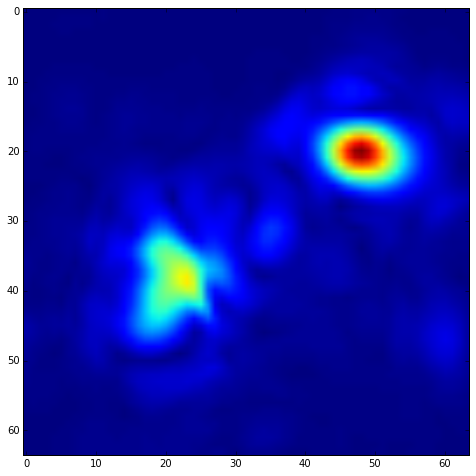

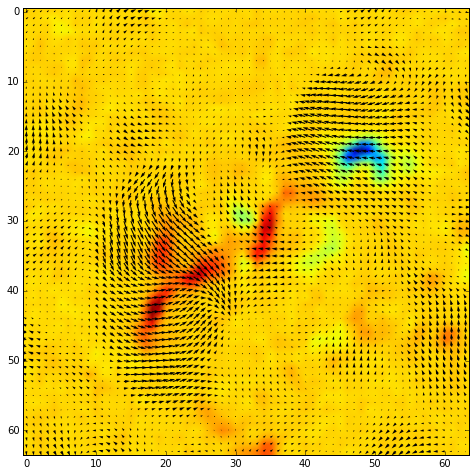

In [12]:
%matplotlib inline

fig = plt.figure(0,[8,8])
q = rot(B,X)
q = np.sqrt(np.sum([q[i]**2 for i in range(0,3)],0))
plt.imshow(q[:,:,5])
plt.show()

fig = plt.figure(1,[8,8])
plt.imshow(data1)
plt.quiver(p1,p2)
plt.show()

In [105]:
f = np.array(force(B,X))
f[:,:,:,0]=0

In [106]:
np.max(np.abs(f))

862.26187167530566

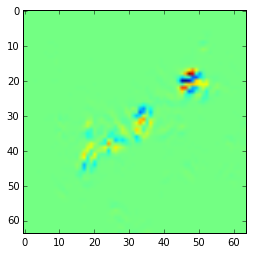

In [82]:
plt.imshow(jacobian(X)[2][0][:,:,1])

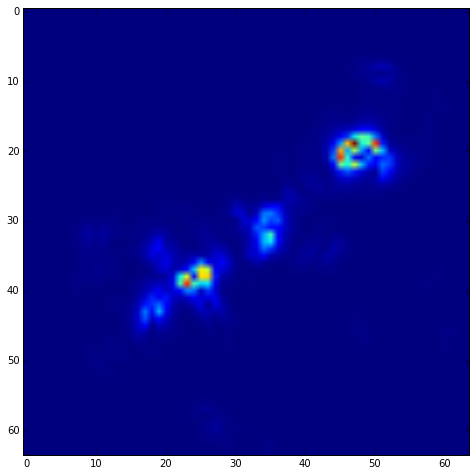

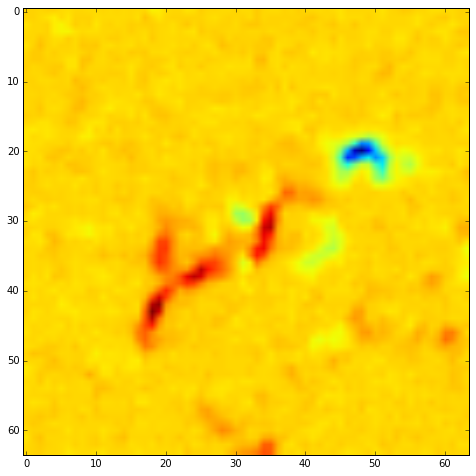

In [76]:
%matplotlib inline

f = np.array(force(B,X))
q = np.sqrt(np.sum([f[i]**2 for i in range(0,3)],0))

fig = plt.figure(0,[8,8])
plt.imshow(q[:,:,2])
plt.show()

fig = plt.figure(1,[8,8])
plt.imshow(data1)
plt.show()


In [195]:
h = hessian(X)

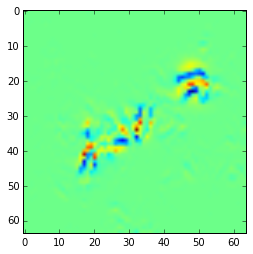

In [207]:
plt.imshow(h[1][2][0][:,:,1])

In [143]:
np.max(np.abs(force(B,X)[2][:,:,10]))

0.1116708636335396

In [41]:
np.sum([i for i in range(0,3)]/4)

TypeError: unsupported operand type(s) for /: 'list' and 'int'